In [30]:
import importlib
from car_part import CarPartDataset, CarPartConfig, prepare_datasets, preprocess_dataset, extract_annotations
from pathlib import Path
import colorsys
import random
import numpy as np
import maskrcnn.model as modellib
from maskrcnn.model import log
from maskrcnn import visualize
import scipy.io as sio
import json

import matplotlib.pyplot as plt
import imageio

## Explore the dataset with the annotations for the car part classification


Plese read the readme.md before running this script

In [2]:
part_annotation_path = Path('./dataset/car_part_annotations/Annotations_Part/')
images_path = Path('./dataset/VOCdevkit/VOC2010/JPEGImages')

In [50]:
part_annotation_path = Path('./dataset/cogito_output_merged.json')
images_path = Path('./dataset/')

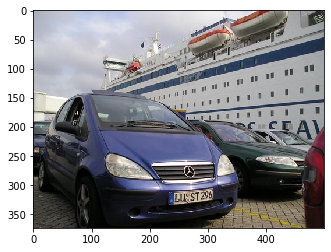

In [44]:

images_annotations_files = list(Path(part_annotation_path).glob('*.mat'))[3:4]
path = images_annotations_files[0]

image_objs = extract_annotations(path)
file_name = path.name.replace('mat', 'jpg')
image_path = images_path / file_name
img = imageio.imread(image_path)
plt.imshow(img)


In [48]:
filter={'car'}
class_names = set()
mask_list = []
class_list = []

for obj in image_objs:
    if obj['class_name'] in filter:
        if 'parts' in obj:
            for part in obj['parts']:
                # handle the mask
                mask_list.append(part['mask'].astype(bool))

                # handle the class name
                part_name = part['part_name']
                class_list.append(part_name)
                class_names.add(part_name)

if len(mask_list):
    # reshape the mask list
    mask_list = np.array(mask_list)
    mask_list = np.moveaxis(mask_list, 0, -1)

## Prepare the datasets

In [3]:
dataset_train, dataset_val, dataset_test, parts_dict =\
    prepare_datasets(images_path, part_annotation_path, 0.1, 0.2)

100%|██████████| 10103/10103 [02:06<00:00, 80.08it/s]len results 1022
train size 102, val size 102 test size 818



In [4]:
colors = visualize.generate_colormap(len(parts_dict), scaled=False)

In [5]:
id_parts_dict = {v:k for k,v in parts_dict.items()}
len(id_parts_dict)

30

### Check some images

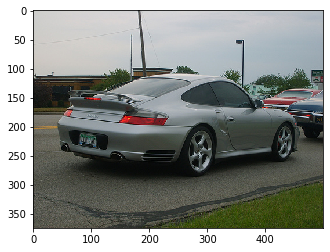

In [6]:
i = 24
img = dataset_train.load_image(i)
plt.imshow(img)

In [26]:
np.any(mask)

True

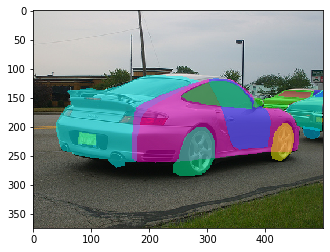

In [24]:
mask, classes = dataset_train.load_mask(i)
img_copy = img.copy()

for l in range(mask.shape[-1]):
    img_copy = visualize.apply_mask(img_copy, mask[:,:,l], colors[l])
    
plt.imshow(img_copy)

In [198]:
print([id_parts_dict[v] for v in classes])

['bliplate', 'backside', 'wheel_1', 'window_1', 'bliplate', 'backside', 'rightside', 'window_1', 'bliplate', 'backside', 'rightside', 'door_1', 'rightmirror', 'wheel_1', 'wheel_2', 'window_1']


In [199]:
print(parts_dict)

{'backside': 1, 'bliplate': 2, 'door_1': 3, 'door_2': 4, 'door_3': 5, 'fliplate': 6, 'frontside': 7, 'headlight_1': 8, 'headlight_2': 9, 'headlight_3': 10, 'headlight_4': 11, 'headlight_5': 12, 'headlight_6': 13, 'leftmirror': 14, 'leftside': 15, 'rightmirror': 16, 'rightside': 17, 'roofside': 18, 'wheel_1': 19, 'wheel_2': 20, 'wheel_3': 21, 'wheel_4': 22, 'wheel_5': 23, 'window_1': 24, 'window_2': 25, 'window_3': 26, 'window_4': 27, 'window_5': 28, 'window_6': 29, 'window_7': 30}


In [18]:
with open('./parts_idx_dict.json', 'w') as f:
    json.dump(parts_dict, f)

In [19]:
!cat parts_idx_dict.json

{"backside": 1, "bliplate": 2, "door_1": 3, "door_2": 4, "door_3": 5, "fliplate": 6, "frontside": 7, "headlight_1": 8, "headlight_2": 9, "headlight_3": 10, "headlight_4": 11, "headlight_5": 12, "headlight_6": 13, "leftmirror": 14, "leftside": 15, "rightmirror": 16, "rightside": 17, "roofside": 18, "wheel_1": 19, "wheel_2": 20, "wheel_3": 21, "wheel_4": 22, "wheel_5": 23, "window_1": 24, "window_2": 25, "window_3": 26, "window_4": 27, "window_5": 28, "window_6": 29, "window_7": 30}

## Image Augmentation

An example of image augmentation applied to the images

In [20]:
import imgaug as ia
import imgaug.augmenters as iaa

In [200]:
image = img
image_mask = mask

In [201]:
segmap = ia.SegmentationMapOnImage(mask, shape=image.shape, nb_classes=len(parts_dict))

In [202]:
augmentation = iaa.OneOf([
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.Affine(scale=(1., 2.5), rotate=(-90, 90), shear=(-16, 16), 
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
    iaa.ContrastNormalization((0.5, 1.5)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),
    iaa.Alpha((0.0, 1.0), iaa.Grayscale(1.0)),
    iaa.LogContrast(gain=(0.6, 1.4)),
    iaa.PerspectiveTransform(scale=(0.01, 0.15)),
    iaa.Clouds(),
    iaa.Noop(),
])

In [203]:
# Augment images and heatmaps.
images_aug = []
segmaps_aug = []
updates = []
for _ in range(10):
    augmentation_det = augmentation.to_deterministic()
    images_aug.append(augmentation_det.augment_image(image))
    segmaps_aug.append(augmentation_det.augment_segmentation_maps([segmap])[0])

In [204]:
len(images_aug)
len(segmaps_aug)

10

In [205]:
cells = []
for image_aug, segmap_aug in zip(images_aug, segmaps_aug):
    cells.append(image)                                      # column 1
    cells.append(segmap.draw_on_image(image))                # column 2
    cells.append(image_aug)                                  # column 3
    cells.append(segmap_aug.draw_on_image(image_aug))        # column 4
    cells.append(segmap_aug.draw(size=image_aug.shape[:2]))  # column 5

In [206]:
for c in cells:
    print(type(c))
    if (type(c)==np.ndarray):
        print(c.shape)
    else:
        print(len(c))

<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500, 3)
<class 'list'>
16
<class 'numpy.ndarray'>
(375, 500,

In [207]:
#[print(f'{i} ---> {(c.shape)}') for i, c in enumerate(cells_np)]
cells_np_m =[] 
for c in cells:
    if (type(c)==np.ndarray):
        cells_np_m.append(c)

In [208]:
cells_list_m =[] 
for c in cells:
    if (type(c)!=np.ndarray):
        cells_list_m.append(np.array(c))

In [65]:
cells_np = [np.array(c) for c in cells]

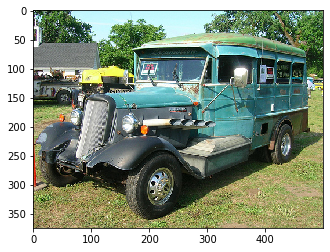

In [134]:
grid_image = ia.draw_grid(cells_np_m, cols=5)
plt.imshow(img)

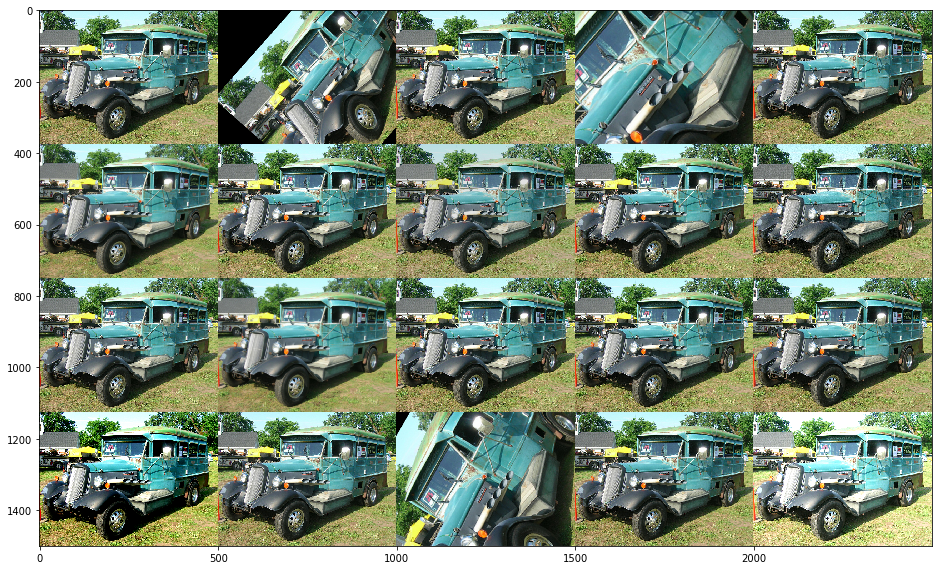

In [136]:
fig = plt.figure(figsize=(16,16))
ax = plt.subplot()
ax.imshow(grid_image)